In [1]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

## Read File

In [2]:
import pandas as pd 

df = pd.read_csv("../../data/sms_with_features.csv")
df.head()

,label,message,char_count,word_count,num_count,has_url,has_email,has_currency,upper_ratio,special_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,0,0,0,0,0.027027,0
1,ham,Ok lar... Joking wif u oni...,29,6,0,0,0,0,0.068966,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,25,0,0,0,0.064516,0
3,ham,U dun say so early hor... U c already then say...,49,11,0,0,0,0,0.040816,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,0,0,0,0,0.032787,0


## Data Preprocessing

In [3]:
df.isnull().sum()

label            0
message          0
char_count       0
word_count       0
num_count        0
has_url          0
has_email        0
has_currency     0
upper_ratio      0
special_count    0
dtype: int64

In [4]:
df.duplicated().sum()
df = df.drop_duplicates()



In [5]:
# Mapping "ham" to 0 and "spam" to 1
df["label"] = df["label"].map({ "ham": 0, "spam": 1})

df.head()

,label,message,char_count,word_count,num_count,has_url,has_email,has_currency,upper_ratio,special_count
0,0,"Go until jurong point, crazy.. Available only ...",111,20,0,0,0,0,0.027027,0
1,0,Ok lar... Joking wif u oni...,29,6,0,0,0,0,0.068966,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,25,0,0,0,0.064516,0
3,0,U dun say so early hor... U c already then say...,49,11,0,0,0,0,0.040816,0
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,0,0,0,0,0.032787,0


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
X = df["message"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
vectorizer = TfidfVectorizer(stop_words="english")
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

X_train_vec.shape, X_test_vec.shape

((3618, 6731), (1551, 6731))

In [7]:
import re # regular expression

# Delete messages that only contain symbols or spaces
df = df[~df["message"].str.strip().eq("")]  # Remove spaces or blanks
df = df[~df["message"].apply(lambda x: bool(re.fullmatch(r"[^a-zA-Z0-9]+", x)))] # delete message that only contain symbols

In [9]:
from sklearn.feature_selection import mutual_info_classif

# to capture non-linear relationship 

# get the most relevant features
mi = mutual_info_classif(X_train_vec.toarray(), y_train, discrete_features=False) #type: ignore
mi

array([0.        , 0.        , 0.        , ..., 0.        , 0.00268576,
       0.00428383], shape=(6731,))

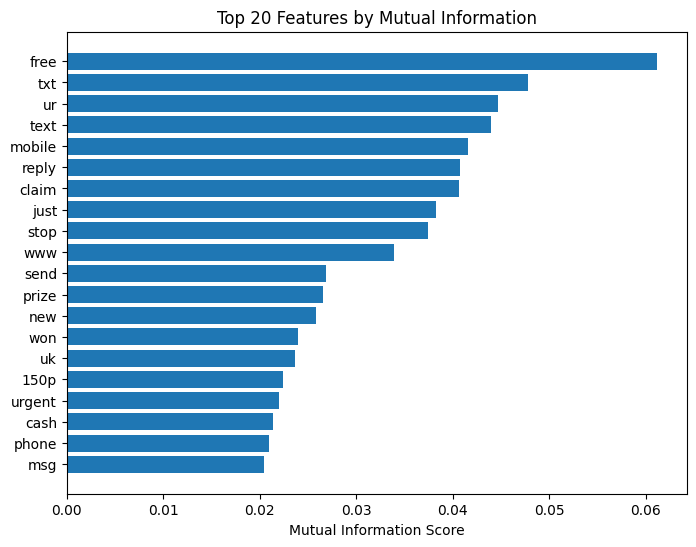

In [ ]:
import numpy as np

# get feature name
feature_names = vectorizer.get_feature_names_out()

# sort by descending order
mi_sorted = np.argsort(mi)[::-1]  
top_features = feature_names[mi_sorted[:20]]  
top_scores = mi[mi_sorted[:20]] # select top 20 highest mutual information scores

# visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.barh(top_features[::-1], top_scores[::-1])
plt.title("Top 20 Features by Mutual Information")
plt.xlabel("Mutual Information Score")
plt.show()

# text contain free might strong indicate spam

## Evaluation and Model Tuning

`Before Tuning`

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vec, y_train) # type: ignore
y_pred = naive_bayes.predict(X_test_vec)


print("Accuracy:", accuracy_score(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.965183752417795
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1345
           1       1.00      0.74      0.85       206

    accuracy                           0.97      1551
   macro avg       0.98      0.87      0.91      1551
weighted avg       0.97      0.97      0.96      1551



`After tuning`

In [ ]:
nb = MultinomialNB()
params_nb = {"alpha": [0.1, 0.5, 1.0]}
grid_nb = GridSearchCV(nb, params_nb, cv=5, scoring="f1")
grid_nb.fit(X_train_vec, y_train)

nb_best = grid_nb.best_estimator_
y_pred_nb = nb_best.predict(X_test_vec)

print("Naive Bayes Best Params:", grid_nb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
# print("confusion_matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Best Params: {'alpha': 0.1}
Accuracy: 0.9832366215344939
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1345
           1       0.97      0.90      0.93       206

    accuracy                           0.98      1551
   macro avg       0.98      0.95      0.96      1551
weighted avg       0.98      0.98      0.98      1551



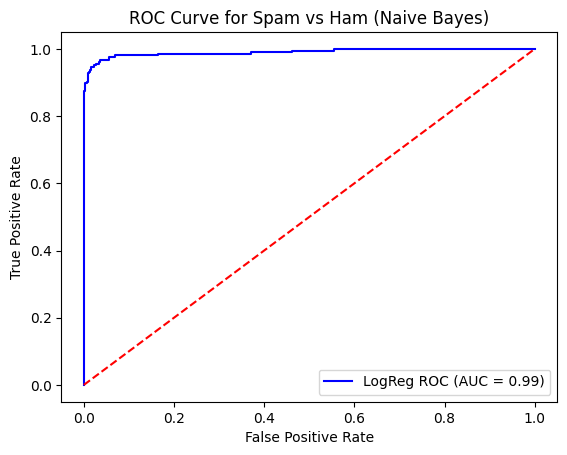

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
y_prob = grid_nb.predict_proba(X_test_vec)[:, 1] #type: ignore


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"LogReg ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Spam vs Ham (Naive Bayes)")
plt.legend()
plt.show()


## Vizualization

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


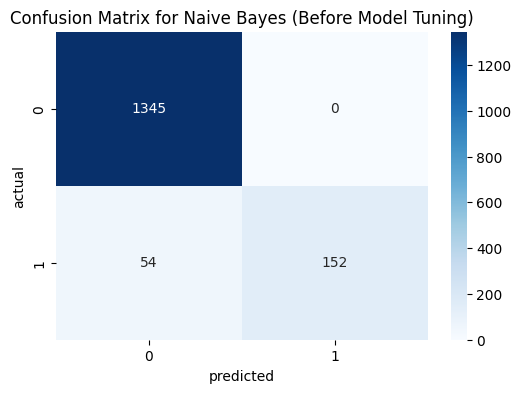

In [ ]:

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True, fmt="d", cmap='Blues')
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("Confusion Matrix for Naive Bayes (Before Model Tuning)")
plt.show()

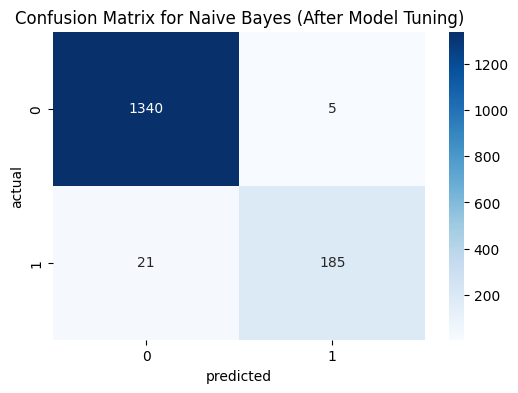

In [ ]:

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred_nb), annot=True, fmt="d", cmap='Blues')
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("Confusion Matrix for Naive Bayes (After Model Tuning)")
plt.show()

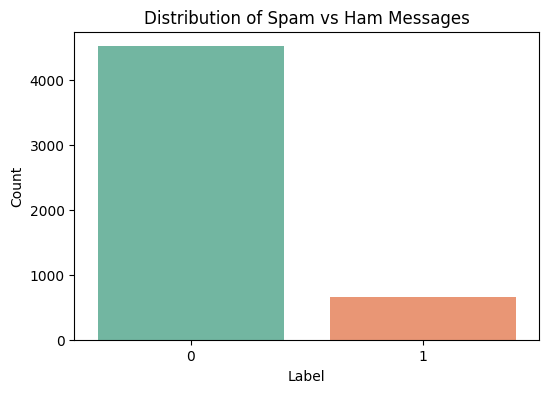

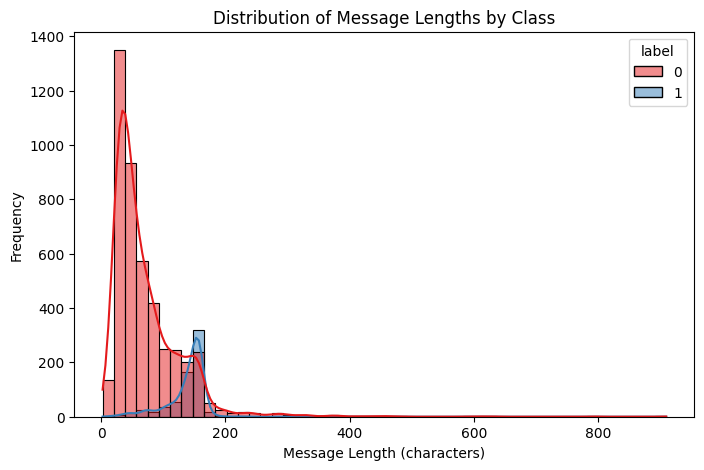

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# label distribution
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df, hue="label", palette="Set2", legend=False)
plt.title("Distribution of Spam vs Ham Messages")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

df["msg_length"] = df["message"].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(data=df, x="msg_length", hue="label", bins=50, kde=True, palette="Set1")
plt.title("Distribution of Message Lengths by Class")
plt.xlabel("Message Length (characters)")
plt.ylabel("Frequency")
plt.show()